# How can we predict the value of the S&P 500?
Jasper Hsu, Thomas Suman, Trey Hensel

## Libraries and dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

## Loading the data: 
https://www.kaggle.com/datasets/gkitchen/s-and-p-500-spy

In [43]:
df = pd.read_csv("spy.csv")

First, we must decide what we are trying to predict. Our dataset supplies us with four options: open, high, low, and close. Predicting the high and low values of the stock on a given day is a seemingly good idea, but this information is hard to use because it is also dependent on time - and we aren't given any data on when the stock hits either extremity. Predicting the value of the stock when the market opens is definitely useful, but it generally doesn't reflect the overall market sentiment and may be heavily influenced by unpredictable overnight news or events. On the other hand, the closing price of a stock reflects the overall market sentiment and demand for the stock at the end of the trading day. It is also widely used as a benchmark for measuring the performance of the stock market. Thus, we will be predicting the closing price.

## Test/train split:

In [46]:
df = df.sample(frac = 1)
train_proportion = 0.8
n = len(df)
split = math.floor(n*train_proportion)

def times_to_timestamps(time_arr):
    # Define a function to convert a single time string to a timestamp
    def time_to_timestamp(time_str):
        time_obj = datetime.strptime(time_str, '%Y-%m-%d')
        timestamp = int(time_obj.timestamp())
        return timestamp
    
    # Use the vectorize function to apply the time_to_timestamp function to every element in the array
    timestamp_arr = np.vectorize(time_to_timestamp)(time_arr)
    
    # Return the resulting array of timestamps
    return timestamp_arr

target = df["Close"]
data = pd.DataFrame(np.array(times_to_timestamps(df["Date"])))

# the following variable records the features of examples in the training set
train_x = data.iloc[:split]
# the following variable records the features of examples in the test set
test_x = data.iloc[split+1:]
# the following variable records the labels of examples in the training set
train_y = target[:split]
# the following variable records the labels of examples in the test set
test_y = target[split+1:]

Note that we converted string data from the "Date" column formatted as "YYYY-MM-DD" to integers, and we are trying to use the "Date" feature to predict the our target "Close" value.

## Attempt #1: Linear Regression Model

Train MSE	 2762.033280607011
Test MSE	 2878.4189800627382


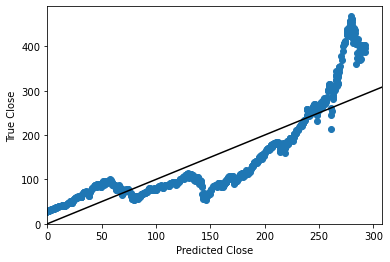

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                 1.795e+04
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        18:19:50   Log-Likelihood:                -32705.
No. Observations:                6078   AIC:                         6.541e+04
Df Residuals:                    6076   BIC:                         6.543e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3.293e-07   2.46e-09    133.964      0.000    3.24e-07    3.34e-07
const       -260.6465      3.038    -85.788      0.000    -266.603    -254.690
==============================================================================
Omnibus:                      614.246   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              850.979
Skew:                           0.807   Prob(JB):                    1.63e-185
Kurtosis:                       3.868   Cond. No.                     5.57e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.57e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [64]:
# This function just computes the mean squared error
def MSE(y, pred):
    return np.mean(np.square(np.subtract(y, pred)))

# This function plots the main diagonal;for a "predicted vs true" plot with perfect predictions, all data lies on this line
def plotDiagonal(xmin, xmax):
    xsamples = np.arange(xmin,xmax,step=0.01)
    plt.plot(xsamples,xsamples,c='black')

# This helper function plots x vs y and labels the axes
def plotdata(x=None,y=None,xname=None,yname=None,margin=0.05,plotDiag=True,zeromin=False):
    plt.scatter(x,y,label='data')
    plt.xlabel(xname)
    plt.ylabel(yname)
    range_x = max(x) - min(x)
    range_y = max(y) - min(y)
    if plotDiag:
        plotDiagonal(min(x)-margin*range_x,max(x)+margin*range_x)
    if zeromin:
        plt.xlim(0.0,max(x)+margin*range_x)
        plt.ylim(0.0,max(y)+margin*range_y)
    else:
        plt.xlim(min(x)-margin*range_x,max(x)+margin*range_x)
        plt.ylim(min(y)-margin*range_y,max(y)+margin*range_y)
    plt.show()

# This function plots the predicted labels vs the actual labels (We only plot the first 1000 points to avoid slow plots)
def plot_pred_true(test_pred=None, test_y=None, max_points = 1000):
    plotdata(test_pred[1:max_points], test_y[1:max_points],'Predicted Close', 'True Close', zeromin=True)

# This function runs OLS and bypasses any SVD (Singular Value Decomposition) convergence errors by refitting the model
def run_OLS(train_y, test_y, train_vals, test_vals):
    ols_model = sm.regression.linear_model.OLS(train_y, train_vals)
    while True: # Bypasses SVD convergence assertion error
        try:
            results = ols_model.fit()
            break
        except:
            None
            
    w = np.array(results.params).reshape([len(results.params),1])

    train_pred = np.matmul(train_vals,w)
    test_pred = np.matmul(test_vals,w)

    train_MSE = MSE(train_y, train_pred.flatten())
    test_MSE = MSE(test_y, test_pred.flatten())
    
    return train_MSE, test_MSE, test_pred, results

train_vals_offset = np.ones(train_x.shape[0]).reshape(-1, 1)
train_vals = np.concatenate([train_x, train_vals_offset], axis=1)

test_vals_offset = np.ones(test_x.shape[0]).reshape(-1, 1)
test_vals = np.concatenate([test_x, test_vals_offset], axis=1)

train_MSE, test_MSE, test_pred, result = run_OLS(train_y, test_y, train_vals, test_vals)

print("Train MSE\t", str(train_MSE))
print("Test MSE\t", str(test_MSE))

plot_pred_true(test_pred.flatten(), test_y)

result.summary()


In [55]:
df = df.sort_values('Date', ascending=True)

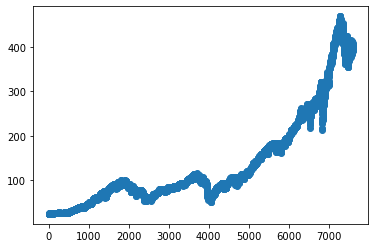

In [57]:
plt.scatter([i for i in range(len(df['Close']))], df['Close'])
plt.show()